# Hymenoptera -Ants and Bees Classification Project

The model in this notebook classifies ants and bees (binary classification task). I used a pre-trained ResNet18 model from pytorch and fine-tuned it for binary classification.



Below are the steps carried out in this notebook: 
- importing and installing appropriate libraries
- downloading the hymenoptera dataset
- Unzipping the dataset.
- Upload the dataset to an S3 bucket.
- confirm if the dataset is in the s3 bucket.
- Setting up hyperparameter tuning.
- Starting a hyperparameter tuning job.
- Record the best hyperparameters as discovered from the above.
- Train a fine-tuned model using ResNet18 and the best hyperparameters, recording profiling and debug data.
- Deploy that model as an endpoint.
- Test that endpoint with new images.
- Delete endpoints

In [1]:
# TODO: Install any packages that you might need
# For instance, you will need the smdebug package
!pip install smdebug

In [2]:
!pip install torchvision==0.5.0 --no-cache-dir

     |████████████████████████████████| 4.0 MB 29.8 MB/s            
     |████████████████████████████████| 753.4 MB 3.7 MB/s             
  Attempting uninstall: torch
    Found existing installation: torch 1.7.1
    Uninstalling torch-1.7.1:
      Successfully uninstalled torch-1.7.1
  Attempting uninstall: torchvision
    Found existing installation: torchvision 0.8.2
    Uninstalling torchvision-0.8.2:
      Successfully uninstalled torchvision-0.8.2


In [3]:
# TODO: Import any   that you might need
# For instance you will need Boto3 and Sagemaker
import sagemaker
import boto3

## Dataset
TODO: Explain what dataset you are using for this project. Maybe even give a small overview of the classes, class distributions etc that can help anyone not familiar with the dataset get a better understand of it.

The dataset used in this project is dog breed classification dataset. It contains 133 dog breeds (classes). Each image has a filename that is its unique id.

In [4]:
#TODO: Fetch and upload the data to AWS S3

# Command to download and unzip data
# !wget https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/dogImages.zip
# !unzip dogImages.zip

!wget https://download.pytorch.org/tutorial/hymenoptera_data.zip
!unzip hymenoptera_data.zip

--2021-12-14 00:29:18--  https://download.pytorch.org/tutorial/hymenoptera_data.zip
Resolving download.pytorch.org (download.pytorch.org)... 13.32.208.57, 13.32.208.73, 13.32.208.88, ...
Connecting to download.pytorch.org (download.pytorch.org)|13.32.208.57|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 47286322 (45M) [application/zip]
Saving to: ‘hymenoptera_data.zip.1’

hymenoptera_data.zi 100%[===================>]  45.10M  28.3MB/s    in 1.6s    

2021-12-14 00:29:19 (28.3 MB/s) - ‘hymenoptera_data.zip.1’ saved [47286322/47286322]

Archive:  hymenoptera_data.zip
replace hymenoptera_data/train/ants/0013035.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: ^C


In [5]:
# checking data details
import os
for _, dirs, files in os.walk('./hymenoptera_data/train'):
    print(len(dirs))
    break

2


In [6]:
# get the sagemaker session
sagemaker_session = sagemaker.Session()

# get s3 bucket
bucket = sagemaker_session.default_bucket()
# bucket = "ant-bees-bucket"

# set the prefix
prefix = "project-hymenoptera/antbees"

# get the sagemaker execution role
role = sagemaker.get_execution_role()

In [7]:
# upload the data to s3 bucket
print(f"Uploading images...")
inputs = sagemaker_session.upload_data(path="hymenoptera_data", bucket = bucket, key_prefix = prefix)
# inputs = "s3://sagemaker-us-east-1-429660041905/project-hymenoptera/antbees"

print(f"input spec (s3 path): {inputs}")

Uploading images...
input spec (s3 path): s3://sagemaker-us-east-1-145842273397/project-hymenoptera/antbees


In [8]:
# confirm that data is in S3 bucket
empty_check = []
for obj in boto3.resource('s3').Bucket(bucket).objects.all():
    empty_check.append(obj.key)
    #print(obj.key)

assert len(empty_check) !=0, 'S3 bucket is empty.'
print('Test passed!')

Test passed!


## Hyperparameter Tuning
**TODO:** This is the part where you will finetune a pretrained model with hyperparameter tuning. Remember that you have to tune a minimum of two hyperparameters. However you are encouraged to tune more. You are also encouraged to explain why you chose to tune those particular hyperparameters and the ranges.

**Note:** You will need to use the `hpo.py` script to perform hyperparameter tuning.

In [9]:
# making imports needed for tuning

from sagemaker.tuner import (
    IntegerParameter,
    CategoricalParameter,
    ContinuousParameter,
    HyperparameterTuner,
)


In [10]:
#TODO: Declare your HP ranges, metrics etc.
hyperparameter_ranges ={
    "lr": sagemaker.tuner.ContinuousParameter(1e-4, 1e-1),
    "batch-size": sagemaker.tuner.CategoricalParameter([32, 64]) #, 256, 512])
}

# metrics
objective_metric_name = "average test loss"
objective_type = "Minimize"
metric_definitions = [{"Name": "average test loss", "Regex": "Test set: Average loss: ([0-9\\.]+)"}]

In [11]:
#TODO: Create estimators for your HPs
from sagemaker.pytorch import PyTorch

# TODO: Your estimator here
estimator = PyTorch(
    entry_point="hpo_Copy.py",
    role=role,
    py_version='py36',
    framework_version="1.8",
    instance_count=1,
    instance_type="ml.m5.xlarge",
)

# TODO: Your HP tuner here
tuner = sagemaker.tuner.HyperparameterTuner(
    estimator,
    objective_metric_name,
    hyperparameter_ranges,
    metric_definitions,
    max_jobs=5,
    max_parallel_jobs=2,
    objective_type=objective_type,
    early_stopping_type="Auto",
)

In [19]:
# s3_train_data = "s3://{}/{}/".format(bucket, "dogImages")
# s3_output_dir = "s3://{}/{}/".format(bucket, "output")
# s3_model_dir = "s3://{}/{}/".format(bucket, "model")

# # os.environ['SM_CHANNEL_TRAINING']= s3_train_data
# os.environ['SM_MODEL_DIR']= s3_model_dir
# os.environ['SM_OUTPUT_DATA_DIR']= s3_output_dir

In [12]:
# TODO: Fit your HP Tuner
# TODO: Remember to include your data channels
tuner.fit({"training": inputs}, wait = True)

......................................................................................................................................................................................!


In [13]:
tuner.best_training_job()

'pytorch-training-211214-0033-001-8b94690f'

In [14]:
# TODO: Get the best estimators and the best HPs

best_estimator = tuner.best_estimator()

#Get the hyperparameters of the best trained model
best_estimator.hyperparameters()


2021-12-14 00:38:07 Starting - Preparing the instances for training
2021-12-14 00:38:07 Downloading - Downloading input data
2021-12-14 00:38:07 Training - Training image download completed. Training in progress.
2021-12-14 00:38:07 Uploading - Uploading generated training model
2021-12-14 00:38:07 Completed - Training job completed


{'_tuning_objective_metric': '"average test loss"',
 'batch-size': '"32"',
 'lr': '0.009295904050552684',
 'sagemaker_container_log_level': '20',
 'sagemaker_estimator_class_name': '"PyTorch"',
 'sagemaker_estimator_module': '"sagemaker.pytorch.estimator"',
 'sagemaker_job_name': '"pytorch-training-2021-12-14-00-33-08-026"',
 'sagemaker_program': '"hpo_Copy.py"',
 'sagemaker_region': '"us-east-1"',
 'sagemaker_submit_directory': '"s3://sagemaker-us-east-1-145842273397/pytorch-training-2021-12-14-00-33-08-026/source/sourcedir.tar.gz"'}

In [15]:
best_hyperparameters= {'batch-size': int(best_estimator.hyperparameters()['batch-size'].replace('"', "")),
                      'lr': best_estimator.hyperparameters()['lr'],

                      }
best_hyperparameters

{'batch-size': 32, 'lr': '0.009295904050552684'}

## Model Profiling and Debugging
TODO: Using the best hyperparameters, create and finetune a new model

**Note:** You will need to use the `train_model.py` script to perform model profiling and debugging.

In [16]:
# TODO: Set up debugging and profiling rules and hooks
from sagemaker.debugger import Rule, ProfilerRule, DebuggerHookConfig, rule_configs, CollectionConfig
from sagemaker.debugger import ProfilerConfig, FrameworkProfile
from smdebug.trials import create_trial
from smdebug.core.modes import ModeKeys

[2021-12-14 00:49:11.240 ip-172-16-35-233:15717 INFO utils.py:27] RULE_JOB_STOP_SIGNAL_FILENAME: None


In [17]:
rules= [
    Rule.sagemaker(rule_configs.vanishing_gradient()),
    Rule.sagemaker(rule_configs.loss_not_decreasing()),
#     ProfilerRule.sagemaker(rule_configs.LowGPUUtilization()),
    ProfilerRule.sagemaker(rule_configs.ProfilerReport()),
    Rule.sagemaker(rule_configs.overfit()),
    Rule.sagemaker(rule_configs.overtraining()),
    Rule.sagemaker(rule_configs.poor_weight_initialization()),
]

In [18]:
collection_configs = [CollectionConfig(name="CrossEntopyLoss_output_0", parameters={
    "include_regex": "CrossEntropyLoss_output_0", "train_save_interval": "100", "eval.save_interval": "10"
})]

profiler_config = ProfilerConfig(
    system_monitor_interval_millis=500, framework_profile_params=FrameworkProfile(num_steps=10)
)

hook_config = DebuggerHookConfig(
   collection_configs = collection_configs
)

In [19]:
# best_hyperparameters = {'batch-size': 32, 'lr': '0.01254233177934059'}

In [20]:
# TODO: Create and fit an estimator
from sagemaker.pytorch import PyTorch

estimator = PyTorch(
    entry_point="train_model_copy.py",
    base_job_name="ant-bees-estimator2",
    role=role,
    instance_count=1,
    instance_type= "ml.m5.2xlarge",
    hyperparameters=best_hyperparameters,
    framework_version="1.8",
    py_version="py36",
    # Debugger parameters
    rules=rules,
    debugger_hook_config=hook_config,
    profiler_config = profiler_config
)

In [21]:
estimator.fit({"training": inputs}, wait=True, logs=True)

2021-12-14 00:51:16 Starting - Starting the training job...
2021-12-14 00:51:18 Starting - Launching requested ML instancesProfilerReport-1639443076: InProgress
......
2021-12-14 00:52:34 Starting - Preparing the instances for training.........
2021-12-14 00:54:14 Downloading - Downloading input data
2021-12-14 00:54:14 Training - Downloading the training image...
2021-12-14 00:54:47 Training - Training image download completed. Training in progress..bash: cannot set terminal process group (-1): Inappropriate ioctl for device
bash: no job control in this shell
2021-12-14 00:54:47,802 sagemaker-training-toolkit INFO     Imported framework sagemaker_pytorch_container.training
2021-12-14 00:54:47,804 sagemaker-training-toolkit INFO     No GPUs detected (normal if no gpus installed)
2021-12-14 00:54:47,812 sagemaker_pytorch_container.training INFO     Block until all host DNS lookups succeed.
2021-12-14 00:54:48,115 sagemaker_pytorch_container.training INFO     Invoking user training scrip

In [22]:
region = sagemaker_session.boto_region_name
training_job_name = estimator.latest_training_job.name
print(f"Training jobname: {training_job_name}")
print(f"Region: {region}")
from smdebug.profiler.analysis.notebook_utils.training_job import TrainingJob

job_name = estimator.latest_training_job.name
client = estimator.sagemaker_session.sagemaker_client
description = client.describe_training_job(TrainingJobName=estimator.latest_training_job.name)

Training jobname: ant-bees-estimator2-2021-12-14-00-51-15-859
Region: us-east-1


In [23]:
# checking training performance
trial = create_trial(estimator.latest_job_debugger_artifacts_path())

[2021-12-14 00:57:15.609 ip-172-16-35-233:15717 INFO s3_trial.py:42] Loading trial debug-output at path s3://sagemaker-us-east-1-145842273397/ant-bees-estimator2-2021-12-14-00-51-15-859/debug-output


In [24]:
# fetch tensor names 
trial.tensor_names()

[2021-12-14 00:57:15.798 ip-172-16-35-233:15717 INFO trial.py:198] Training has ended, will refresh one final time in 1 sec.
[2021-12-14 00:57:16.818 ip-172-16-35-233:15717 INFO trial.py:210] Loaded all steps


['CrossEntropyLoss_output_0']

In [25]:
# TODO: Plot a debugging output.
# Set up functions to plot the output tensors

def get_data(trial, tname, mode):
    tensor = trial.tensor(tname)
    steps = tensor.steps(mode=mode)
    vals = []
    for s in steps:
        vals.append(tensor.value(s, mode=mode))
    return steps, vals

In [26]:
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import host_subplot


def plot_tensor(trial, tensor_name):

    steps_train, vals_train = get_data(trial, tensor_name, mode=ModeKeys.TRAIN)
    print("loaded TRAIN data")
    steps_eval, vals_eval = get_data(trial, tensor_name, mode=ModeKeys.EVAL)
    print("loaded EVAL data")

    fig = plt.figure(figsize=(10, 7))
    host = host_subplot(111)

    par = host.twiny()

    host.set_xlabel("Steps (TRAIN)")
    par.set_xlabel("Steps (EVAL)")
    host.set_ylabel(tensor_name)

    (p1,) = host.plot(steps_train, vals_train, label=tensor_name)
    print("completed TRAIN plot")
    (p2,) = par.plot(steps_eval, vals_eval, label="val_" + tensor_name)
    print("completed EVAL plot")
    leg = plt.legend()

    host.xaxis.get_label().set_color(p1.get_color())
    leg.texts[0].set_color(p1.get_color())

    par.xaxis.get_label().set_color(p2.get_color())
    leg.texts[1].set_color(p2.get_color())

    plt.ylabel(tensor_name)

    plt.show()

loaded TRAIN data
loaded EVAL data
completed TRAIN plot
completed EVAL plot


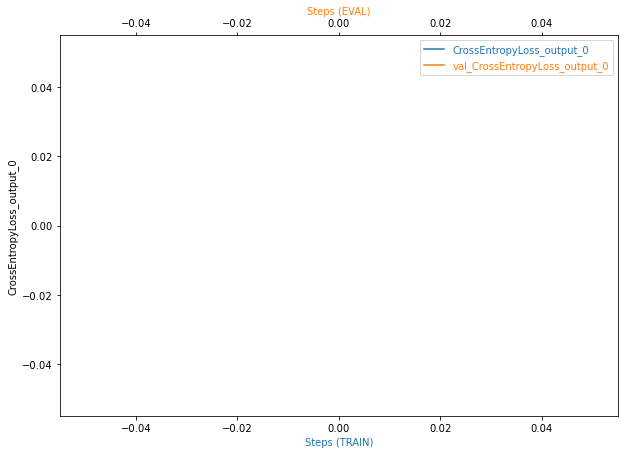

In [27]:
plot_tensor(trial, "CrossEntropyLoss_output_0")

In [48]:
# plot_tensor(trial, "CrossEntropyLoss_output_3")

**TODO**: Is there some anomalous behaviour in your debugging output? If so, what is the error and how will you fix it?  
**TODO**: If not, suppose there was an error. What would that error look like and how would you have fixed it?

There is no debugging error from the estimator output and cloudwatch logs. Loss decreases steadily and also accuracy increases. However,  I had issues with smdebug hooks, thus the graph did not show any plots. I will have to find why it is not compatible with my model and fix it.
Also, if the loss was increasing, I would try using different learning rates. if model overfits, I will also try data augmentation as well.

In [29]:
# check system utilization
from smdebug.profiler.analysis.notebook_utils.training_job import TrainingJob

tj = TrainingJob(training_job_name, region)
tj.wait_for_sys_profiling_data_to_be_available()

ProfilerConfig:{'S3OutputPath': 's3://sagemaker-us-east-1-145842273397/', 'ProfilingIntervalInMilliseconds': 500}
s3 path:s3://sagemaker-us-east-1-145842273397/ant-bees-estimator2-2021-12-14-00-51-15-859/profiler-output


Profiler data from system is available


In [30]:
from smdebug.profiler.analysis.notebook_utils.timeline_charts import TimelineCharts

system_metrics_reader = tj.get_systems_metrics_reader()
system_metrics_reader.refresh_event_file_list()

view_timeline_charts = TimelineCharts(
    system_metrics_reader,
    framework_metrics_reader=None,
    select_dimensions=["CPU", "GPU"],
    select_events=["total"],
)

[2021-12-14 00:58:21.085 ip-172-16-35-233:15717 INFO metrics_reader_base.py:134] Getting 4 event files
select events:['total']
select dimensions:['CPU', 'GPU']
filtered_events:{'total'}
filtered_dimensions:{'CPUUtilization-nodeid:algo-1'}


In [31]:
# TODO: Display the profiler output
rule_output_path = estimator.output_path + estimator.latest_training_job.job_name + "/rule-output"
print(f"You will find the profiler report in {rule_output_path}")

You will find the profiler report in s3://sagemaker-us-east-1-145842273397/ant-bees-estimator2-2021-12-14-00-51-15-859/rule-output


In [32]:
! aws s3 ls {rule_output_path} --recursive

2021-12-14 00:56:39     329722 ant-bees-estimator2-2021-12-14-00-51-15-859/rule-output/ProfilerReport-1639443076/profiler-output/profiler-report.html
2021-12-14 00:56:38     171090 ant-bees-estimator2-2021-12-14-00-51-15-859/rule-output/ProfilerReport-1639443076/profiler-output/profiler-report.ipynb
2021-12-14 00:56:35        191 ant-bees-estimator2-2021-12-14-00-51-15-859/rule-output/ProfilerReport-1639443076/profiler-output/profiler-reports/BatchSize.json
2021-12-14 00:56:35        199 ant-bees-estimator2-2021-12-14-00-51-15-859/rule-output/ProfilerReport-1639443076/profiler-output/profiler-reports/CPUBottleneck.json
2021-12-14 00:56:35        126 ant-bees-estimator2-2021-12-14-00-51-15-859/rule-output/ProfilerReport-1639443076/profiler-output/profiler-reports/Dataloader.json
2021-12-14 00:56:35        127 ant-bees-estimator2-2021-12-14-00-51-15-859/rule-output/ProfilerReport-1639443076/profiler-output/profiler-reports/GPUMemoryIncrease.json
2021-12-14 00:56:35        198 ant-bees-es

In [33]:
! aws s3 cp {rule_output_path} ./ --recursive

download: s3://sagemaker-us-east-1-145842273397/ant-bees-estimator2-2021-12-14-00-51-15-859/rule-output/ProfilerReport-1639443076/profiler-output/profiler-reports/CPUBottleneck.json to ProfilerReport-1639443076/profiler-output/profiler-reports/CPUBottleneck.json
download: s3://sagemaker-us-east-1-145842273397/ant-bees-estimator2-2021-12-14-00-51-15-859/rule-output/ProfilerReport-1639443076/profiler-output/profiler-reports/LowGPUUtilization.json to ProfilerReport-1639443076/profiler-output/profiler-reports/LowGPUUtilization.json
download: s3://sagemaker-us-east-1-145842273397/ant-bees-estimator2-2021-12-14-00-51-15-859/rule-output/ProfilerReport-1639443076/profiler-output/profiler-reports/Dataloader.json to ProfilerReport-1639443076/profiler-output/profiler-reports/Dataloader.json
download: s3://sagemaker-us-east-1-145842273397/ant-bees-estimator2-2021-12-14-00-51-15-859/rule-output/ProfilerReport-1639443076/profiler-output/profiler-reports/LoadBalancing.json to ProfilerReport-163944307

In [34]:
# get the autogenerated folder name of profiler report
profiler_report_name = [
    rule["RuleConfigurationName"]
    for rule in estimator.latest_training_job.rule_job_summary()
    if "Profiler" in rule["RuleConfigurationName"]
][0]

In [35]:
import IPython

IPython.display.HTML(filename=profiler_report_name + "/profiler-output/profiler-report.html")

## Model Deploying

In [36]:
# TODO: Add your deployment configuration like instance type and number of instances
predictor2 = estimator.deploy(initial_instance_count=1, instance_type="ml.t2.medium")

-----------!

In [37]:
predictor2.endpoint_name

'ant-bees-estimator2-2021-12-14-00-58-46-392'

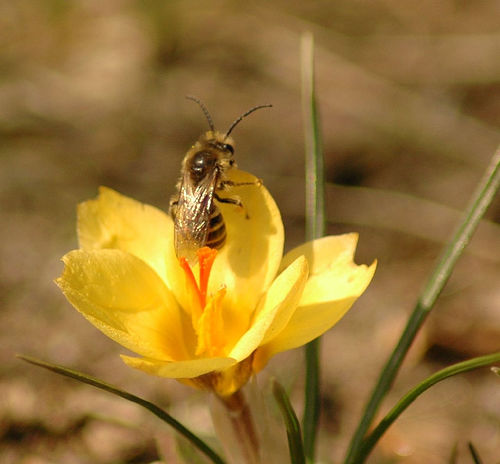

In [38]:
from IPython.display import Image
file_name = './hymenoptera_data/val/bees/10870992_eebeeb3a12.jpg'

Image(file_name)

In [39]:
# !pip install smdebug
# !jupyter-lab --NotebookApp.iopub_data_rate_limit=1e10
# !pip install torchvision==0.5.0

In [40]:
# !pwd

In [41]:
import json
import requests
import torch
import torchvision
import PIL
import torchvision.transforms as transforms
import numpy as np

transform = transforms.Compose([
        transforms.Resize(256),
        transforms.RandomCrop(224),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ])

PIL_image = PIL.Image.open("./hymenoptera_data/val/bees/10870992_eebeeb3a12.jpg")

image = transform(PIL_image)

payload = image.unsqueeze(dim=0)

response = predictor2.predict(payload)

np.argmax(response) + 1

2

In [43]:
# 2nd approach to make inference
PIL_image = PIL.Image.open("./hymenoptera_data/val/bees/177677657_a38c97e572.jpg")

image = transform(PIL_image)

payload = image.unsqueeze(dim=0)

response = predictor2.predict(payload)

np.argmax(response) + 1

2

In [44]:
print(response)

[[-4.29114723  5.73238707]]


In [46]:
# TODO: Remember to shutdown/delete your endpoint once your work is done
predictor2.delete_endpoint()